# Foreword

This script performs a flood risk assessment for an area of interest given flood hazard maps for different return periods for that AOI.

# Import packages

In [1]:
import geopandas as gpd
import requests
from shapely.geometry import shape
from shapely import wkt
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
from datetime import datetime
import os
import warnings
import subprocess
from sqlalchemy import create_engine, text
import psycopg2
from geoalchemy2 import Geometry
import glob

warnings.filterwarnings('ignore')

# Functions

In [32]:
def raster_to_polygon(input_raster, output_datasource, layer_name, variable):
    
    # Construct the command to execute the gdal_polygonize.py script
    cmd = f'gdal_polygonize.py -q -overwrite -of PostgreSQL {input_raster} {output_datasource} {layer_name} {variable}'
    print(cmd)

    # Execute the command
    os.system(cmd)
    

# Create PostGIS database

In [15]:
# PostGIS DB credentials
dbname = "lyon"
dbuser = "postgres"
dbpass = "postgres"
dbhost = "localhost"
dbport = "5432"

# Create PostGIS database
# command = f'createdb -E UTF8 {dbname}'
# os.system(command)

# Create connection to created database
db_connection_url = 'postgresql://' + dbuser + ':' + dbpass + '@' + dbhost + ':' + dbport + '/' + dbname
con = create_engine(db_connection_url)

# Execute the SQL command to create the PostGIS extension
query = text("CREATE EXTENSION IF NOT EXISTS postgis;")
with con.connect() as connection:
    connection.execute(query)
    connection.commit()

# Exposure

## Microsoft Buildings

Source: https://github.com/microsoft/GlobalMLBuildingFootprints/tree/main?tab=readme-ov-file

Text(97.06097121312156, 0.5, 'Latitude (degrees)')

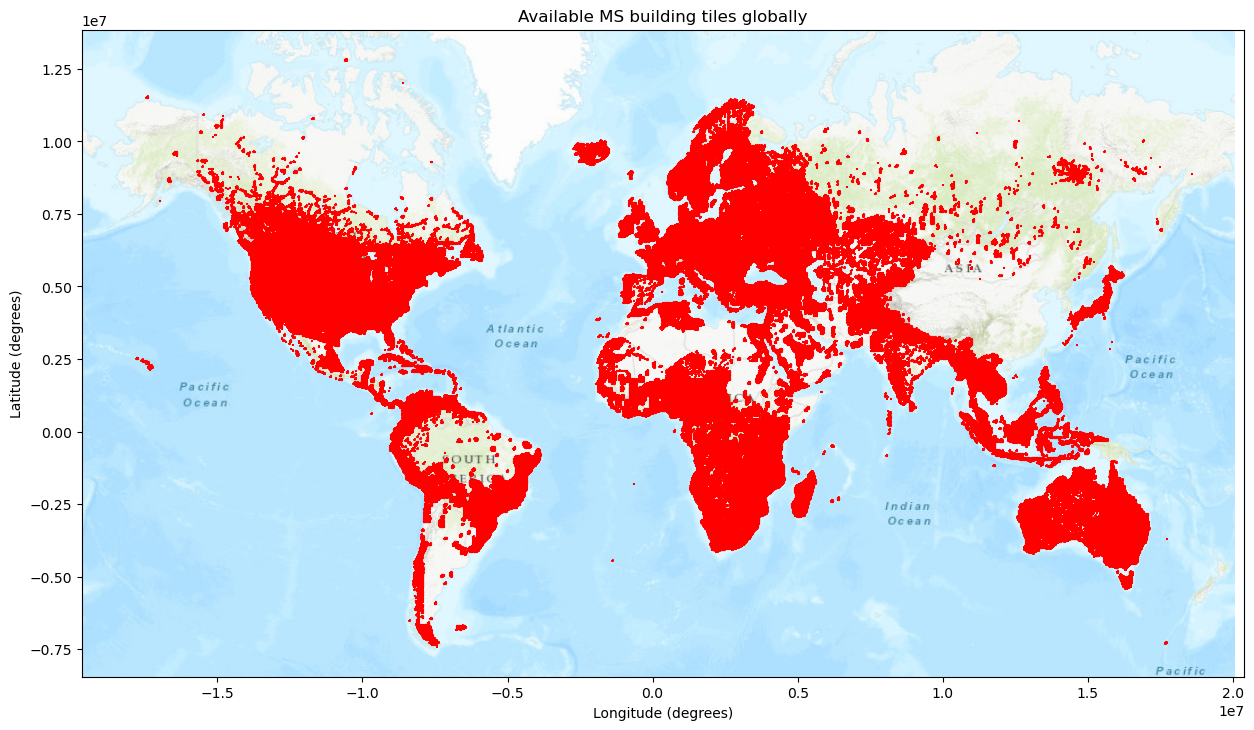

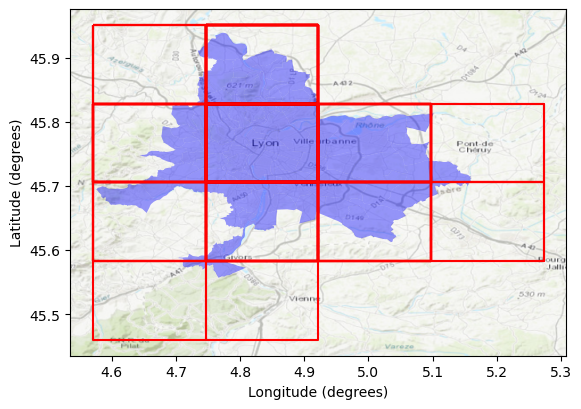

In [34]:
# Read MS building Tiles

url_tiles = 'https://minedbuildings.blob.core.windows.net/global-buildings/buildings-coverage.geojson'
response = requests.get(url_tiles)
gdf_tiles = gpd.read_file(io.BytesIO(response.content))

# Plot Microsoft Buildings available tiles at global scale

fig, ax = plt.subplots(figsize=(15,10))

gdf_tiles.to_crs(3857).boundary.plot(ax=ax, color='red')
cx.add_basemap(ax=ax, source=cx.providers.Esri.WorldTopoMap, attribution=False)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
ax.set_title('Available MS building tiles globally')

# Read AOI

gdf_aoi = gpd.read_file('/Users/aprida/Documents/Consulting/Private_sector/Keolis/Sites_Keolis/communes.shp').to_crs(4326)

# Identify tiles intersecting AOI

gdf_aoi_tiles = gpd.sjoin(gdf_tiles, gdf_aoi, predicate='intersects').reset_index(drop=True)

# Plot selected tiles and AOI

fig, ax = plt.subplots()

gdf_aoi_tiles.boundary.plot(ax=ax, color='red')
gdf_aoi.plot(ax=ax, color='blue', alpha=0.4)
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap, attribution=False)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

In [35]:
t_start = datetime.now()

# Identify url of identified tiles intersecting AOI

dataset_links = pd.read_csv("https://minedbuildings.blob.core.windows.net/global-buildings/dataset-links.csv")
quadkeys = gdf_aoi_tiles['quadkey'].apply(lambda x: int(str(x)[:-2])).unique() ##### CHECK SELECTION OF STRINGS [:-2], NOT SURE IF CODE CORRECT ########
dataset_links_aoi = dataset_links[dataset_links['QuadKey'].isin(quadkeys)]
print(dataset_links_aoi.to_markdown())

# Download polygons falling within AOI

gdf_buildings = gpd.GeoDataFrame()

for _, row in dataset_links_aoi.iterrows(): # merge buildings within identified tiles
    df = pd.read_json(row.Url, lines=True)
    df['geometry'] = df['geometry'].apply(shape)
    gdf = gpd.GeoDataFrame(df, crs=4326)
    gdf_buildings = pd.concat([gdf_buildings, gdf], ignore_index=True)

gdf_buildings_aoi = gpd.sjoin(gdf_buildings, gdf_aoi, predicate='intersects').reset_index(drop=True) # Identify buildings within AOI
gdf_buildings_aoi.to_file('/Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/exposure/pols_lyon.geojson') # Save buildings within AOI to file

print(datetime.now() - t_start)

|       | Location   |   QuadKey | Url                                                                                                                                                                                                    | Size   |
|------:|:-----------|----------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------|
| 10897 | France     | 120220330 | https://minedbuildings.blob.core.windows.net/global-buildings/2024-02-27/global-buildings.geojsonl/RegionName%3DFrance/quadkey%3D120220330/part-00154-efab36e1-2ca3-4fce-a407-aab1d1f93da4.c000.csv.gz | 32.9MB |
| 10898 | France     | 120220331 | https://minedbuildings.blob.core.windows.net/global-buildings/2024-02-27/global-buildings.geojsonl/RegionName%3DFrance/quadkey%3D120220331/part-00116-efab36e1-2ca3-4fce-a407-aab1d1f93da4.c000.csv.gz | 28.8MB |
| 10899 | France    

## Google Open Buildings

Source: https://sites.research.google/open-buildings/#download

Text(128.58086045958146, 0.5, 'Latitude (degrees)')

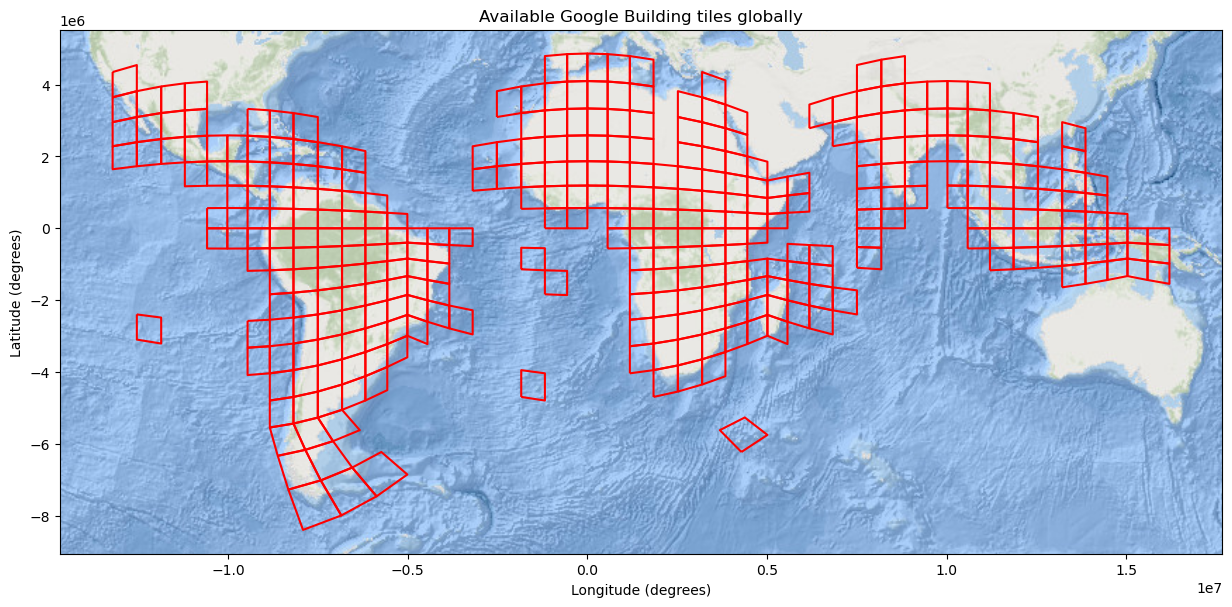

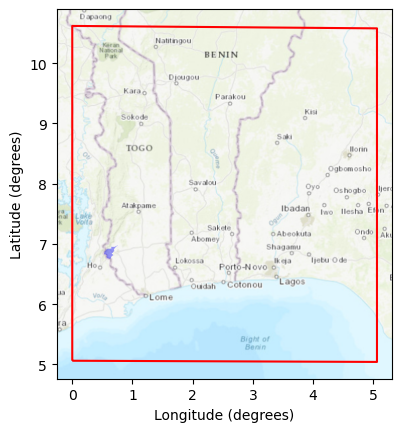

In [36]:
# Read Google Building Tiles

url_tiles = 'https://openbuildings-public-dot-gweb-research.uw.r.appspot.com/public/tiles.geojson'
response = requests.get(url_tiles)
geojson_data = response.json()
gdf_tiles = gpd.GeoDataFrame.from_features(geojson_data['features'], crs=4326)

# Plot Microsoft Buildings available tiles at global scale

fig, ax = plt.subplots(figsize=(15,10))

gdf_tiles.to_crs(3857).boundary.plot(ax=ax, color='red')
cx.add_basemap(ax=ax, source=cx.providers.Esri.OceanBasemap, attribution=False)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
ax.set_title('Available Google Building tiles globally')

# # Read AOI

gdf_aoi = gpd.read_file('/Users/aprida/Documents/Consulting/Public_sector/IDF_Togo/data/admin/admin_kloto1.geojson')

# Identify tiles intersecting AOI

gdf_aoi_tiles = gpd.sjoin(gdf_tiles, gdf_aoi, predicate='intersects').reset_index(drop=True)

# Plot selected tiles and AOI

fig, ax = plt.subplots()

gdf_aoi_tiles.boundary.plot(ax=ax, color='red')
gdf_aoi.plot(ax=ax, color='blue', alpha=0.4)
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap, attribution=False)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

In [ ]:
# Download polygons falling within selected tile

t_start = datetime.now()

output_path = '/Users/aprida/Desktop/buildings.csv.gz'
tile_path = gdf_aoi_tiles.tile_url[0]
os.system(f'wget -O {output_path} {tile_path}') # Download zip file to local (faster than scrapping the data from url)

df = pd.read_csv('/Users/aprida/Desktop/buildings.csv.gz') # Read file with polygons within the preselected tile as dataframe
df['geometry'] = df['geometry'].apply(wkt.loads) # Convert geometry column to WKT format
gdf_buildings = gpd.GeoDataFrame(df, geometry='geometry') # Read polygons as geodataframe

gdf_buildings_aoi = gpd.sjoin(gdf_buildings, gdf_aoi, predicate='intersects').reset_index(drop=True) # Identify buildings within AOI
gdf_buildings_aoi.to_file('/Users/aprida/Desktop/pols_togo.geojson') # Save buildings within AOI to file

print(datetime.now() - t_start)

# Vulnerability

## Property Damage

### HAZUS Depth Damage Functions (DDF)

- Source: https://github.com/nhrap-hazus/FAST/blob/main/Lookuptables
- Metric: % damage over total value of asset.
- Asset is split into Structure, Content and Inventory. Very specific occupancies.
- Functions developed based on surveys and expert knowledge in US.

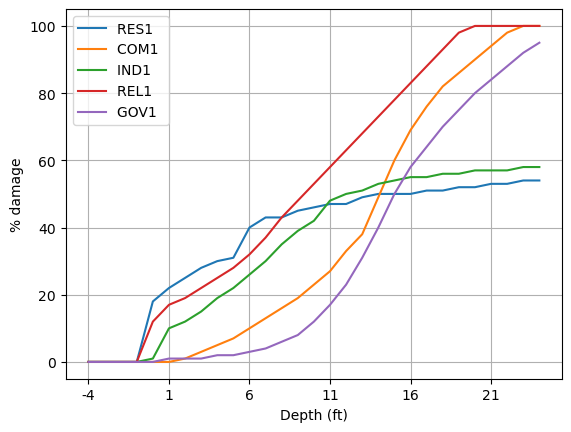

In [37]:
###### How to read file directly from GitHub? ######

ddf_path = '/Users/aprida/Desktop/AllDDF.xlsx'
df_ddf = pd.read_excel(ddf_path, sheet_name='flBldgStructDmgFn') # ['flBldgStructDmgFn': Structural damage, 'flBldgContDmgFn': Building content damage, 'flBldgInvDmgFn': Building inventory damage]
depth = np.arange(-4, 25, 1) # Damage functions start at -4ft and end at 24ft

for i, new_name in enumerate(depth, start=4): # Rename cols with actual depth values
    df_ddf = df_ddf.rename(columns={df_ddf.columns[i]: new_name})

# Select specific functions based on desired Occupancy

ddf_id = [105, 252, 545, 630, 632] # Select ID of the desired functions
df_ddf_sel = pd.DataFrame()

for id in ddf_id:

    occupancy = df_ddf[df_ddf['BldgDmgFnID']==id]['Occupancy'].reset_index(drop=True)[0]
    df_ddf_sel[occupancy] = df_ddf[df_ddf['BldgDmgFnID']==id].iloc[:, 4:-1].T

# df_ddf_sel.index = df_ddf_sel.index * 0.3048

# Plot depth damage functions

fig, ax = plt.subplots()
df_ddf_sel.plot(ax=ax)
ax.set_xlabel('Depth (ft)')
ax.set_ylabel('% damage')
ax.grid()

### JRC
- Source: https://publications.jrc.ec.europa.eu/repository/bitstream/JRC105688/copy_of_global_flood_depth-damage_functions__30102017.xlsx
- Metric: % damage over maximum flood damage.
- Occupancies are grouped into 6 classes.
- Functions developed based on surveys in different continents.

In [45]:
ddf_path = 'https://publications.jrc.ec.europa.eu/repository/bitstream/JRC105688/copy_of_global_flood_depth-damage_functions__30102017.xlsx'
df_ddf = pd.read_excel(ddf_path, sheet_name='Damage functions', skiprows=2).iloc[:, :9] # Select columns with damage functions (next columns include standard deviation)
df_ddf.rename(columns={'Unnamed: 0': 'Occupancy', 'Unnamed: 1': 'Depth', 'North AMERICA': 'NORTH AMERICA', 'Centr&South\nAMERICA': 'SOUTH AMERICA'}, inplace=True)
df_ddf['Occupancy'] = df_ddf['Occupancy'].fillna(method='ffill') # Fill rows with Occupancies
df_ddf = df_ddf.pivot(index='Depth', columns=['Occupancy']) # Aggregate de functions for different occupancies per continent
df_ddf

EUROPE                                            \
Occupancy Agriculture Commercial buildings Industrial buildings   
Depth                                                             
0.0              0.00                 0.00                 0.00   
0.5              0.30                 0.15                 0.15   
1.0              0.55                 0.30                 0.27   
1.5              0.65                 0.45                 0.40   
2.0              0.75                 0.55                 0.52   
3.0              0.85                 0.75                 0.70   
4.0              0.95                 0.90                 0.85   
5.0              1.00                 1.00                 1.00   
6.0              1.00                 1.00                 1.00   

                                                                  \
Occupancy Infrastructure - roads Residential buildings Transport   
Depth                                                              
0.0                         0.00                  0.00  0.000000   
0.5                         0.25                  0.25  0.316667   
1.0                         0.42                  0.40  0.541667   
1.5                         0.55                  0.50  0.701667   
2.0                         0.65                  0.60  0.831667   
3.0                         0.80                  0.75  1.000000   
4.0                         0.90                  0.85  1.000000   
5.0                         1.00                  0.95  1.000000   
6.0                         1.00                  1.00  1.000000   

          NORTH AMERICA                                            \
Occupancy   Agriculture Commercial buildings Industrial buildings   
Depth                                                               
0.0            0.018575             0.018405             0.025714   
0.5            0.267798             0.239264             0.322857   
1.0            0.473677             0.374233             0.511429   
1.5            0.550561             0.466258             0.637143   
2.0            0.602161             0.552147                 0.74   
3.0            0.760057             0.687117                 0.86   
4.0            0.874095             0.822086             0.937143   
5.0            0.954076             0.907975                 0.98   
6.0                   1                    1                    1   

                                  ...              OCEANIA  \
Occupancy Infrastructure - roads  ... Industrial buildings   
Depth                             ...                        
0.0                            -  ...                    -   
0.5                            -  ...                    -   
1.0                            -  ...                    -   
1.5                            -  ...                    -   
2.0                            -  ...                    -   
3.0                            -  ...                    -   
4.0                            -  ...                    -   
5.0                            -  ...                    -   
6.0                            -  ...                    -   

                                                                      GLOBAL  \
Occupancy Infrastructure - roads Residential buildings Transport Agriculture   
Depth                                                                          
0.0                            -                     0         -           0   
0.5                            -              0.475418         -    0.236418   
1.0                            -              0.640393         -    0.466379   
1.5                            -              0.714615         -    0.616485   
2.0                            -              0.787726         -    0.706707   
3.0                            -               0.92878         -    0.817514   
4.0                            -              0.967382         -    0.914524   
5.0                

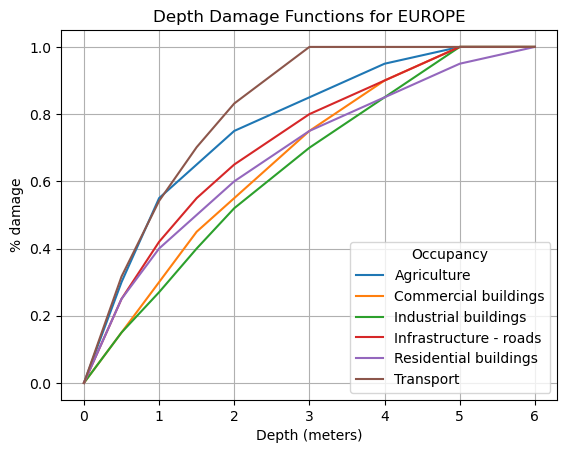

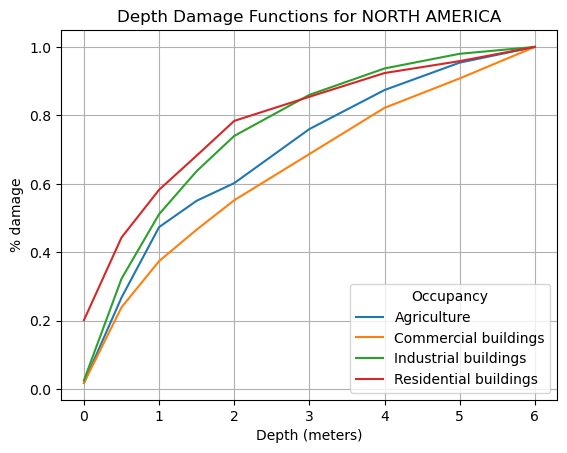

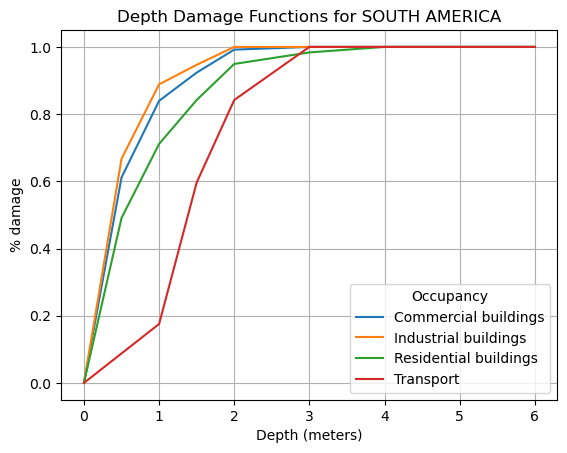

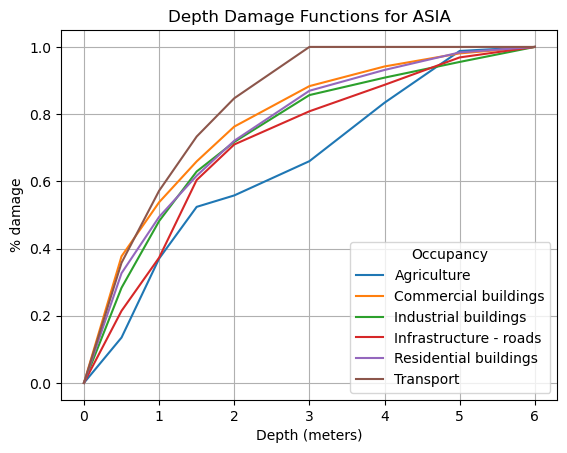

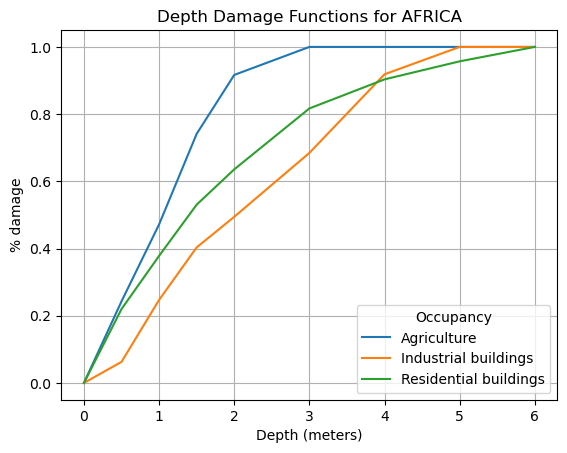

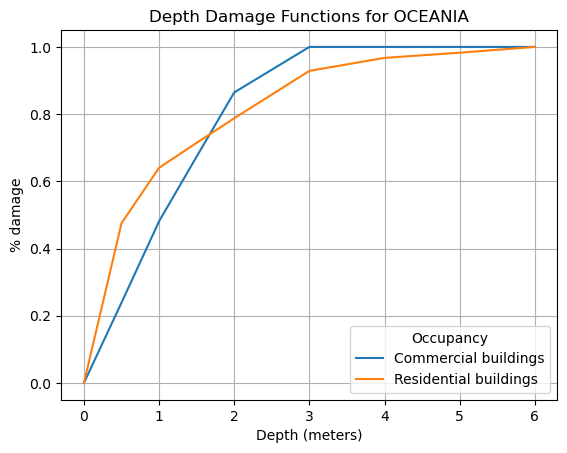

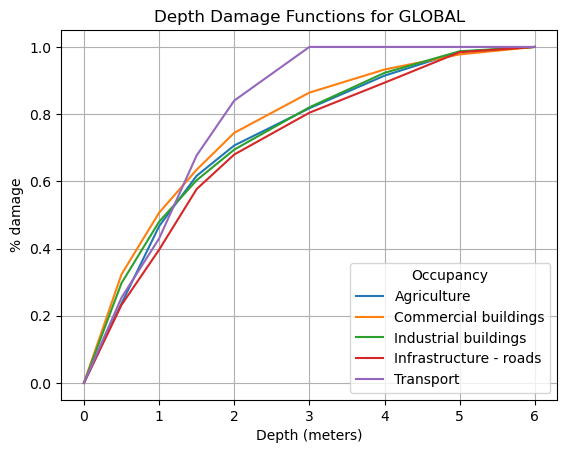

In [40]:
# Plot curves

continents = df_ddf.columns.get_level_values(None).unique()

for continent in continents:

    fig, ax = plt.subplots()
    df_ddf[continent].plot(ax=ax)
    ax.set_xlabel('Depth (meters)')
    ax.set_ylabel('% damage')
    ax.set_title(f'Depth Damage Functions for {continent}')
    ax.grid()

### Assign Occupancy to each polygon

To test: OSM, LULC sources.

In [ ]:
gdf_buildings_aoi_occ = gpd.read_file('/Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/exposure/pols_lyon.geojson') # Store geodataframe in another variable
occ_types = ['Commercial buildings', 'Industrial buildings', 'Residential buildings'] # Test occupancies = ['Commercial buildings', 'Industrial buildings', 'Residential buildings'] # Test occupancies
gdf_buildings_aoi_occ['occupancy'] = np.random.choice(occ_types, size=len(gdf_buildings_aoi_occ)) # Assign randomly the test occupancies (for testing purposes)
gdf_buildings_aoi_occ.head(5)

In [ ]:
# Upload buildings to PostGIS database

gdf_buildings_aoi_occ.to_postgis(name='buildings_ms_lyon', con=con, index=True, if_exists='replace', index_label='buildings_ms_lyon_id',
                      dtype={'geometry': Geometry(geometry_type='POLYGON', srid=4326)
                             })

# Hazard

In [ ]:
def get_s3_folder_list(bucket_name, prefix):
    s3_client = boto3.client('s3')
    response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix, Delimiter='/')

    folders = []
    for common_prefix in response.get('CommonPrefixes', []):
        folder_name = common_prefix['Prefix'].strip('/')
        folders.append(folder_name)

    return folders

def define_north_south(val):
    if val < 0:
        return 's'
    else:
        return 'n'

def define_west_east(val):
    if val < 0:
        return 'w'
    else:
        return 'e'

def tiles_fathom_glob(): # Global tiles of Fathom Global Flood Maps (1 arcdeg resolution)

    # Define the bounding box coordinates
    xmin, xmax, ymin, ymax = -180, 180, -90, 90

    # Define the resolution (in degrees)
    resolution = 1

    # Calculate the number of rows and columns based on the resolution
    num_rows = int(np.ceil((ymax - ymin) / resolution))
    num_cols = int(np.ceil((xmax - xmin) / resolution))

    # Create a list to hold the grid cells
    grid_cells = []

    # Create the grid cells
    for row in range(num_rows):
        for col in range(num_cols):
            x_left = xmin + col * resolution
            x_right = x_left + resolution
            y_top = ymax - row * resolution
            y_bottom = y_top - resolution

            # Create a Polygon for the grid cell
            cell = Polygon([(x_left, y_top), (x_right, y_top), (x_right, y_bottom), (x_left, y_bottom)])

            # Append the cell to the list
            grid_cells.append({'geometry': cell})

    # Create a DataFrame from the list of grid cells
    grid = gpd.GeoDataFrame(grid_cells)

    # Set the coordinate reference system (CRS)
    grid.crs = 'EPSG:4326'

    gdf_tiles_fathom = pd.concat([grid, grid.bounds], axis=1)

    tile_names = gdf_tiles_fathom.apply(lambda x: define_north_south(x['miny']) +
                                   "{:02d}".format(int(abs(x['miny']))) +
                                   define_west_east(x['minx']) +
                                   "{:03d}".format(int(abs(x['minx']))),
                                   axis=1)

    gdf_tiles_fathom.insert(0, 'tile_name', tile_names)
    gdf_tiles_fathom = gdf_tiles_fathom[['tile_name', 'geometry']]

    return (gdf_tiles_fathom)

In [ ]:
import boto3
from shapely import Polygon, box

# Specify your S3 bucket name and prefix (directory) where flood data is located

bucket_name = 'axa-climate-datastore-shared-internal-prod'
prefix = 'Flood_RiskMap_Fathom/v3/'

scenario_list = get_s3_folder_list(bucket_name, prefix) # List of all folders of Fathom data (all scenarios)

# Identify flood scenarios

# Version (correct version of the data is v3.0)
search_string = 'v3.0.0'
scenario_list = [element for element in scenario_list if search_string  not in element]

# Time horizons
search_string = ['2011'] #  Options: ['2011', '2030', '2050']
scenario_list = [element for element in scenario_list if any(search_strings in element for search_strings in search_string)]

# # Flood type
search_string = ['FLUVIAL'] # Options: ['FLUVIAL', 'PLUVIAL', 'COASTAL']
scenario_list = [element for element in scenario_list if any(search_strings in element for search_strings in search_string)]

# # Return period
search_string = ['1in5-', '1in10-', '1in20-', '1in50-','1in100-', '1in200-', '1in500-', '1in1000-'] # Options: ['1in5-', '1in10-', '1in20-', '1in50-', '1in100-', '1in200-', '1in500-', '1in1000-']
scenario_list = [element for element in scenario_list if any(search_strings in element for search_strings in search_string)]

# # Defences
search_string = 'UNDEFENDED'
scenario_list = [element for element in scenario_list if search_string in element]

# # Socioeconomic Pathway
search_string = ['2011'] # Options: ['SSP1', 'SSP2', 'SSP5']
scenario_list = [element for element in scenario_list if any(search_strings in element for search_strings in search_string)]

# # Percentile
search_string = 'PERCENTILE50'
scenario_list = [element for element in scenario_list if search_string in element]

print(pd.DataFrame(scenario_list).to_markdown())

# Generate global Fathom tile grid

gdf_tiles_fathom = tiles_fathom_glob()

# Select Fathom tiles based on assets of interest

tiles_sel = gpd.sjoin(gdf_tiles_fathom, gdf_aoi.dissolve(), predicate='intersects').reset_index(drop=True) # Identify tiles that fall within the bbox of the assets geojson
tiles_sel = tiles_sel.set_crs(4326)
print(pd.DataFrame(tiles_sel.iloc[:,:2]).to_markdown())

In [ ]:
import rasterio as rio
import rioxarray as rxr
from rioxarray.merge import merge_arrays

# Create a directory for outputs flood maps (figures)

fathom_dir = '/Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/fathom' # Save buildings within AOI to file
os.makedirs(fathom_dir, exist_ok=True)

# Extract flood depth values per scenario

for scenario in scenario_list:
        
    # Merge fathom flood tiles in case an asset intersects more than one tile
    
    raster_to_mosaic = []

    try:
        for row, index in tiles_sel.iterrows():
            raster_path = os.path.join('s3://axa-climate-datastore-shared-internal-prod', scenario, index['tile_name']) + '.tif'
            raster = rxr.open_rasterio(raster_path, chunks=True)
            raster_to_mosaic.append(raster)
    except:
        continue
    
    # Extract flood values per pixel within asset polygon
    
    merged_raster = merge_arrays(raster_to_mosaic)
    merged_raster.rio.write_crs('EPSG:4326', inplace=True)
    merged_raster.values[merged_raster.values == 0] = -32767
    merged_raster.rio.write_nodata(-32767, inplace=True)
    flood_map_raster = os.path.join(fathom_dir, scenario.split('/')[-1] + '.tif')
    merged_raster.rio.to_raster(flood_map_raster)

In [ ]:
t_start = datetime.now()

# Read paths to flood hazard rasters
fl_hazard_dir = '/Users/aprida/Documents/Consulting/Private_sector/Keolis/Model_Alvaro/fathom'
fl_hazard_rasters = glob.glob(os.path.join(fl_hazard_dir, '*.tif'))

# Set PostGIS target data source and colname of the polygonized attribute
target_datasource = f'PG:"dbname={dbname} user={dbuser} password={dbpass} host={dbhost} port={dbport}"'
variable = 'depth'

# Upload flood hazard vector files to PostGIS database
for raster in fl_hazard_rasters:

    table_name = 'RP' + '_'.join(raster.split('/')[-1].split('.')[0].split('-')[3:-1]).split('in')[-1]
    raster_to_polygon(raster, target_datasource, table_name, variable) # Polygonize reclassified raster
    ##### If tables already exist in PostGIS, this does not work #####

print(datetime.now() - t_start)

# Flood risk assessment

In [98]:
# List tables with flood depth vector layers

query = """
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public';
"""

table_names = pd.read_sql(query, con)['table_name']
table_names = [element for element in table_names if element.startswith('rp')]

# Extract maximum flood depth per polygon

gdf_max_fl = gpd.GeoDataFrame()

for table_name in table_names:
    
    query = f"""
    with tmp as (select b.buildings_ms_lyon_id,
                        coalesce(max(f.depth), 0) as max_flood_depth
                 from buildings_ms_lyon as b
                          left join {table_name} as f
                               on st_intersects(b.geometry, f.wkb_geometry)
                 group by b.buildings_ms_lyon_id)
    select m.buildings_ms_lyon_id,
           m.max_flood_depth,
           b.occupancy,
           round(st_area(b.geometry::geography)::numeric, 2) as area_m2,
           b.geometry
    from tmp as m
             join
         buildings_ms_lyon as b
         on
             m.buildings_ms_lyon_id = b.buildings_ms_lyon_id;
    """

    # Execute the SQL command to create the PostGIS extension
    gdf_tmp = gpd.read_postgis(text(query), con, geom_col='geometry')
    gdf_tmp['scenario'] = table_name
    gdf_max_fl = pd.concat([gdf_max_fl, gdf_tmp]).reset_index(drop=True)

gdf_max_fl = gdf_max_fl.pivot_table(index=['buildings_ms_lyon_id', 'occupancy'], columns='scenario', values='max_flood_depth')

# Sort columns based on numerical part
rp = [int(col.split('_')[0].split('rp')[-1]) for col in gdf_max_fl.columns]
sorted_columns = [col for _, col in sorted(zip(rp, gdf_max_fl.columns))]
gdf_max_fl = gdf_max_fl[sorted_columns]
gdf_max_fl.head(10)

,scenario,rp5_fluvial_undefended_depth_2011_percentile50,rp10_fluvial_undefended_depth_2011_percentile50,rp20_fluvial_undefended_depth_2011_percentile50,rp50_fluvial_undefended_depth_2011_percentile50,rp100_fluvial_undefended_depth_2011_percentile50,rp200_fluvial_undefended_depth_2011_percentile50,rp1000_fluvial_undefended_depth_2011_percentile50
buildings_ms_lyon_id,occupancy,,,,,,,
0,Commercial buildings,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Residential buildings,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Commercial buildings,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Residential buildings,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Industrial buildings,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Residential buildings,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Residential buildings,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Commercial buildings,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Residential buildings,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [217]:
# Compute AEL per building

gdf_ael = gdf_max_fl.copy()
gdf_ael['ael_perc'] = 0

for index, row in gdf_max_fl.iterrows():

    if np.any(row.values != 0):
    
        # Compute AEP table
        
        df_loss = pd.DataFrame({
            'rp': sorted(rp),
            'prob': [1 / x for x in sorted(rp)],
            'depth': row.values / 100
        })

        # Add probability = 0 (last row of AEP table)
        last_row = df_loss.iloc[-1].copy()  # Copy the last row
        last_row['prob'] = 0  # Set probability to 0
        df_loss = pd.concat([df_loss, last_row.to_frame().T], ignore_index=True)

        # Add probability = 1 (first row of AEP table): To perform interpolation when values at RP5 are already high
        first_row = df_loss.iloc[0].copy()  # Copy the first row
        first_row['rp'] = 1  # Set rp to 1
        first_row['prob'] = 1  # Set probability to 1
        first_row['depth'] = 0  # Set depth to 0
        df_loss = pd.concat([pd.DataFrame([first_row]), df_loss], ignore_index=True)
        
        df_loss['loss'] = df_loss.apply(lambda row: np.interp(row['depth'], df_ddf[continent].index, df_ddf[continent][occupancy]), axis=1)
        
        # Compute AEL using trapezoidal rule
        
        x = df_loss.prob.values
        y = df_loss.loss.values
        h = np.diff(x)
        
        gdf_ael.at[index, 'ael_perc'] = -np.sum((y[:-1] + y[1:]) * h / 2)
        
    else:
        pass

The AEL is 57.61 %.


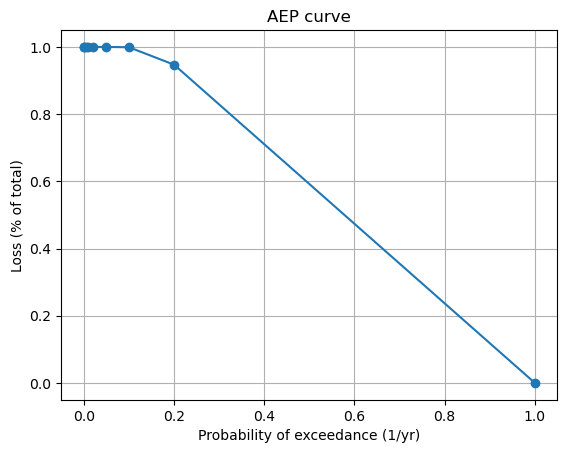

In [237]:
# Plot specific case to check that interpolation approach is applied correctly

df_loss = pd.DataFrame({
    'rp': sorted(rp),
    'prob': [1 / x for x in sorted(rp)],
    'depth': gdf_max_fl.loc[192108, 'Industrial buildings'].values / 100
})

# Add probability = 0 (last row of AEP table)
last_row = df_loss.iloc[-1].copy()  # Copy the last row
last_row['prob'] = 0  # Set probability to 0
df_loss = pd.concat([df_loss, last_row.to_frame().T], ignore_index=True)

# Add probability = 1 (first row of AEP table): To perform interpolation when values at RP5 are already high
first_row = df_loss.iloc[0].copy()  # Copy the first row
first_row['rp'] = 1  # Set rp to 1
first_row['prob'] = 1  # Set probability to 1
first_row['depth'] = 0  # Set depth to 0
df_loss = pd.concat([pd.DataFrame([first_row]), df_loss], ignore_index=True)

df_loss['loss'] = df_loss.apply(lambda row: np.interp(row['depth'], df_ddf[continent].index, df_ddf[continent][occupancy]), axis=1)

# Compute AEL using trapezoidal rule

x = df_loss.prob.values
y = df_loss.loss.values
h = np.diff(x)

area = -np.sum((y[:-1] + y[1:]) * h / 2)
print(f'The AEL is {round(area * 100, 2)} %.')

# Plot AEP curve for this case

fig, ax = plt.subplots()

df_loss.plot(x='prob', y='loss', marker='o', ax=ax)
ax.set_xlabel('Probability of exceedance (1/yr)')
ax.set_ylabel('Loss (% of total)')
ax.set_title('AEP curve')
ax.legend().remove()
ax.grid()

In [251]:
# Join building geometries table with buildings AEL table

query = """
select b.buildings_ms_lyon_id, b.geometry
from buildings_ms_lyon as b;
"""

gdf_buildings_geom = gpd.read_postgis(text(query), con, geom_col='geometry', index_col='buildings_ms_lyon_id')
gdf_buildings_ael = gdf_ael.reset_index('occupancy')

gdf_buildings_ael = gpd.GeoDataFrame(gdf_buildings_ael.join(gdf_buildings_geom), geometry='geometry')

# Upload AEL building layer to PostGIS database

gdf_buildings_ael.to_postgis(name='buildings_ms_ael_lyon', con=con, index=True, if_exists='replace',
                      dtype={'geometry': Geometry(geometry_type='POLYGON', srid=4326)
                             })